## ***PINNs for parametric problems vs Greedy*** ###

Train a PINN to solve the following parametric problem on
${\Omega} = (0, 1) \times (0, 1)$

$$
\begin{cases}
\nabla \cdot ({\mu_1} \nabla u) + \boldsymbol{\beta}\cdot \nabla{u}= 0 & \text{in } \Omega,\\
{\mu_1} \nabla u \cdot \mathbf{n} = \mu_2 & \text{in } \Gamma_{b},\\
u = 0 & \text{in } \Gamma_{tl},\\
 \nabla u \cdot \mathbf{n} = 0 & \text{otherwise},
\end{cases}
$$

where $\mathbf{n}$ is the outer-normal to the portion of $\partial \Omega$ we consider.
Specifically, $\Gamma_b = [0, 1] \times \{0\}$ and $\Gamma_{tl} = ([0, 1] \times \{1\}) \cup (\{0\} \times [0,1])$.

The convection field is $\boldsymbol{\beta} = [y(1-y),0]^T$ and $(x,y)$ represent a spatial coordinate in $\Omega$.
The parametric space is $\mathcal P = [0.1, 10] \times [-1,1]$.

In [55]:
#### IMPORTING EVERYTHING WE NEED ####
%reset -f
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import random as random
import time as time
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

seme = 1000

In [56]:
# Choice of the parameters of the neural network
N_sample = 10000    # nominal value 10000
n_punti = N_sample
n_punti_interni = N_sample
n_parametri_mu = N_sample
n_neurons = 30              # nominal value 20

In [57]:
class Net(nn.Module):     # 3 layers in standard simulation
    def __init__(self):
        super(Net, self).__init__()
        self.input_layer = nn.Linear(4,n_neurons)
        self.hidden_layer1 = nn.Linear(n_neurons,n_neurons)
        self.hidden_layer2 = nn.Linear(n_neurons,n_neurons)
        self.output_layer = nn.Linear(n_neurons,1)

    def forward(self, x,y,mu_1,mu_2):
        input = torch.cat([x,y,mu_1,mu_2],axis=1)
        layer1_out = torch.sigmoid(self.input_layer(input))
        layer2_out = torch.sigmoid(self.hidden_layer1(layer1_out))
        layer3_out = torch.tanh(self.hidden_layer2(layer2_out))
        output = self.output_layer(layer3_out)

        return output * x * (y-1)

In [58]:
torch.manual_seed(seme)  # fix the seed for neural network
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seme)

net = Net()
mse_cost_function = torch.nn.MSELoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [59]:
### Neumann Boundary conditions
def Neumann_dx(net,mu_1,mu_2):     # Neumann bc on right edge
    x_bc_n = np.ones((n_punti,1))
    y_bc_n = np.random.uniform(low=0.0, high=1.0, size=(n_punti,1))
    pt_x_bc = Variable(torch.from_numpy(x_bc_n).float(), requires_grad=True)
    pt_y_bc = Variable(torch.from_numpy(y_bc_n).float(), requires_grad=True)
    u = net(pt_x_bc, pt_y_bc,mu_1, mu_2)
    u_x = torch.autograd.grad(u.sum(), pt_x_bc, create_graph=True)[0]
    return u_x - 0.

def Neumann_sotto(net,mu_1,mu_2):     #  Neumann bc on underside
    x_bc_n = np.random.uniform(low=0.0, high=1.0, size = (n_punti,1))
    y_bc_n = np.zeros((n_punti,1))
    pt_x_bc = Variable(torch.from_numpy(x_bc_n).float(), requires_grad=True)
    pt_y_bc = Variable(torch.from_numpy(y_bc_n).float(), requires_grad=True)
    u = net(pt_x_bc, pt_y_bc,mu_1, mu_2)
    u_y = torch.autograd.grad(u.sum(), pt_y_bc, create_graph=True)[0]
    return - mu_1 * u_y - mu_2

In [60]:
### Residual of the PDE
def Beta_fun(x,y):
  xn = x.detach().numpy()
  yn = y.detach().numpy()

  return torch.Tensor(yn*(1-yn))

def R(x,y, net):
    u = net(x,y,mu_1, mu_2)
    #Derivatives
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_y = torch.autograd.grad(u.sum(), y, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y.sum(), y, create_graph=True)[0]
    beta = Beta_fun(x,y)

    return mu_1 * (u_xx+u_yy) + beta * u_x

In [61]:
### Training
# Seeds for samples of x, y , mu_1, mu_2
np.random.seed(seme)
torch.manual_seed(seme)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seme)

iterations = 15000

train_loss = []

# Ranges of mu_1 and mu_2
mu_1_min = 0.1
mu_1_max = 10
mu_2_min = -1
mu_2_max = 1

#Defining the list of mu we will train on
mu_1 = np.random.uniform(low = mu_1_min, high = mu_1_max, size = (n_parametri_mu,1))
mu_2 = np.random.uniform(low = mu_2_min, high = mu_2_max, size = (n_parametri_mu,1))
mu_1 = Variable(torch.from_numpy(mu_1).float(), requires_grad=False)
mu_2 = Variable(torch.from_numpy(mu_2).float(), requires_grad=False)


for epoch in range(iterations):
    optimizer.zero_grad()

    #Neumann conditions
    tmp = np.zeros((n_punti,1))

    net_neumann_sotto = Neumann_sotto(net,mu_1,mu_2)
    target_neumann_sotto = Variable(torch.from_numpy(tmp).float(), requires_grad=False)
    mse_n_sotto = mse_cost_function(net_neumann_sotto, target_neumann_sotto)

    net_neumann_dx = Neumann_dx(net,mu_1,mu_2)
    target_neumann_dx = Variable(torch.from_numpy(tmp).float(), requires_grad=False)
    mse_n_dx = mse_cost_function(net_neumann_dx, target_neumann_dx)

    ##################################################################################
    # Loss based on PDE
    x_collocation = np.random.uniform(low=0.0, high=2.0, size=(n_punti_interni,1))
    y_collocation = np.random.uniform(low=0.0, high=2.0, size=(n_punti_interni,1))
    all_zeros = np.zeros((n_punti_interni,1))

    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True)
    pt_y_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True)

    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False)
    f_out = R(pt_x_collocation, pt_y_collocation, net)
    mse_f = mse_cost_function(f_out, pt_all_zeros)

    # Combining the loss functions
    loss_bc_neu =  mse_n_dx + mse_n_sotto
    loss_pde = mse_f

    loss =  1000000 * mse_n_sotto + 10 * mse_n_dx  + 10000 * loss_pde

    loss.backward()
    optimizer.step()

    train_loss.append(loss.data.item())

    with torch.autograd.no_grad():
      print(epoch,"Loss:",loss.item())


Output streaming troncato alle ultime 5000 righe.
10000 Loss: 19776.36328125
10001 Loss: 20131.232421875
10002 Loss: 19610.08203125
10003 Loss: 19362.2890625
10004 Loss: 20107.16015625
10005 Loss: 20626.572265625
10006 Loss: 20139.626953125
10007 Loss: 20950.0625
10008 Loss: 20220.41015625
10009 Loss: 20249.634765625
10010 Loss: 20722.87890625
10011 Loss: 20420.01953125
10012 Loss: 19423.21875
10013 Loss: 20431.556640625
10014 Loss: 21118.357421875
10015 Loss: 20546.150390625
10016 Loss: 20499.150390625
10017 Loss: 20073.560546875
10018 Loss: 19642.42578125
10019 Loss: 19622.876953125
10020 Loss: 19782.26953125
10021 Loss: 21379.109375
10022 Loss: 18928.828125
10023 Loss: 19646.375
10024 Loss: 20284.353515625
10025 Loss: 20687.818359375
10026 Loss: 19753.68359375
10027 Loss: 20344.248046875
10028 Loss: 20280.69921875
10029 Loss: 20140.10546875
10030 Loss: 20756.275390625
10031 Loss: 20290.697265625
10032 Loss: 20858.46484375
10033 Loss: 19622.935546875
10034 Loss: 19595.15234375
10035 

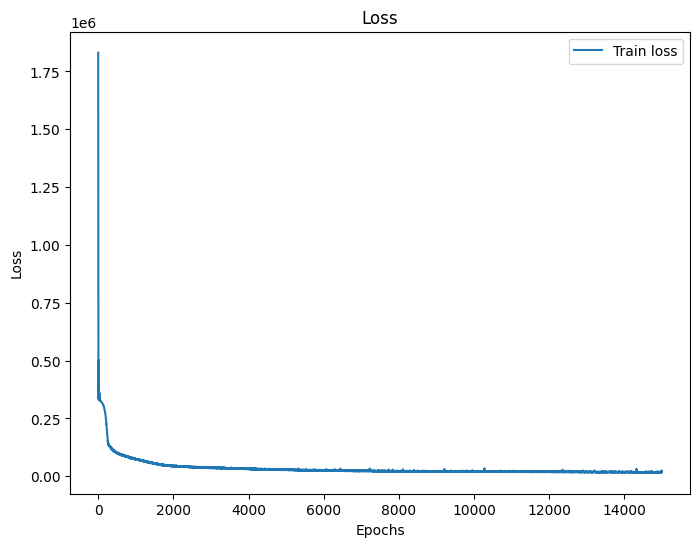

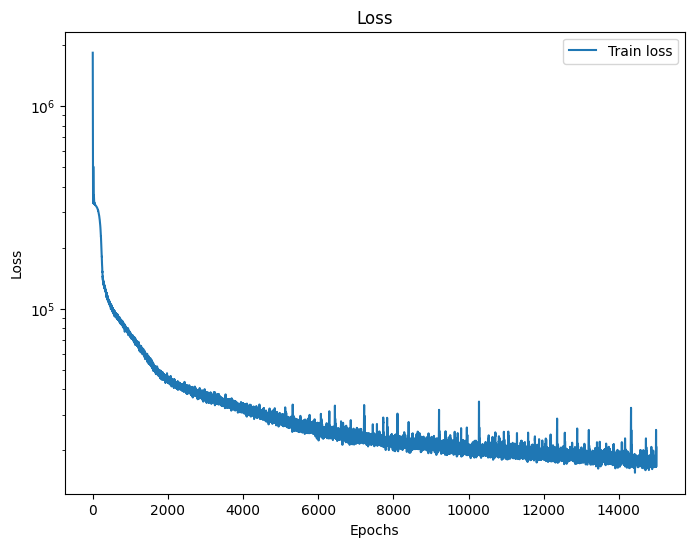

In [62]:
# Visualizing train data
plt.figure(figsize=(8, 6))
epochs = np.arange(iterations)

#plt.plot(epochs,test_loss,label="Test loss")
plt.plot(epochs,train_loss,label="Train loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))

plt.semilogy(epochs,train_loss,label="Train loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()

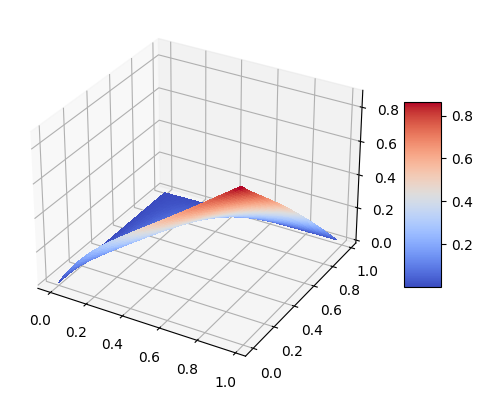

max value of u
0.87941605
min value of u
0.0


In [63]:
#Plot for the PINN
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

x=np.arange(0,1,0.02)
y=np.arange(0,1,0.02)

ms_x, ms_y = np.meshgrid(x, y)

## Just because meshgrid is used, we need to do the following adjustment
x = np.ravel(ms_x).reshape(-1,1)
y = np.ravel(ms_y).reshape(-1,1)

mu_1 = 1 * torch.ones(x.shape[0],1)
mu_2 = 1 * torch.ones(x.shape[0],1)

pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True)
pt_y = Variable(torch.from_numpy(y).float(), requires_grad=True)
pt_u = net(pt_x,pt_y,mu_1,mu_2)
u=pt_u.data.cpu().numpy()
ms_u = u.reshape(ms_x.shape)

surf = ax.plot_surface(ms_x,ms_y,ms_u, cmap=cm.coolwarm,linewidth=0, antialiased=False)

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

print('max value of u')
print(np.max(u))
print('min value of u')
print(np.min(u))

Ora valutiamo l'errore attraverso la libreria gedim

In [64]:
%%capture
!git clone https://github.com/fvicini/CppToPython.git
%cd CppToPython

In [65]:
%%capture
!git submodule init
!git submodule update

In [66]:
%%capture
!mkdir -p externals
%cd externals
!cmake -DINSTALL_VTK=OFF -DINSTALL_LAPACK=OFF ../gedim/3rd_party_libraries
!make -j4
%cd ..

In [67]:
%%capture
!mkdir -p release
%cd release
!cmake -DCMAKE_PREFIX_PATH="/content/CppToPython/externals/Main_Install/eigen3;/content/CppToPython/externals/Main_Install/triangle;/content/CppToPython/externals/Main_Install/tetgen;/content/CppToPython/externals/Main_Install/googletest" ../
!make -j4 GeDiM4Py
%cd ..

In [68]:
import numpy as np
%cd CppToPython
import GeDiM4Py as gedim

[Errno 2] No such file or directory: 'CppToPython'
/content/CppToPython/CppToPython/CppToPython


In [69]:
lib = gedim.ImportLibrary("./release/GeDiM4Py.so")
config = { 'GeometricTolerance': 1.0e-8 }
gedim.Initialize(config, lib)

In [70]:
def Poisson_a(numPoints, points):
	values = np.ones(numPoints)
	return values.ctypes.data

def Poisson_b(numPoints, points):
 matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
 values = np.zeros(numPoints)
 for p in range(0, numPoints):
		values[p] = (matPoints[1,p] * (1.0 - matPoints[1,p]))
		return values.ctypes.data

def Poisson_c(numPoints, points):
	values = np.ones(numPoints)
	return values.ctypes.data

def Poisson_f(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values = np.zeros(numPoints)
	return values.ctypes.data

def Poisson_strongTerm(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values = np.zeros(numPoints)
	return values.ctypes.data

def Poisson_weakTerm_right(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values = np.zeros(numPoints)
	return values.ctypes.data

def Poisson_weakTerm_sotto(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values = np.ones(numPoints)
	return values.ctypes.data

In [71]:
### order of the discretization ###
meshSize = 0.002
order = 2

In [72]:
domain = { 'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1,0,1,1], 'EdgesBoundaryCondition': [3,2,1,1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': meshSize }
[meshInfo, mesh] = gedim.CreateDomainSquare(domain, lib)

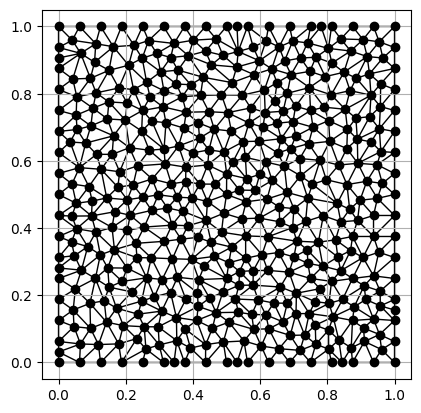

In [73]:
gedim.PlotMesh(mesh)

In [74]:
discreteSpace = { 'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2, 3, 3] }
[problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)

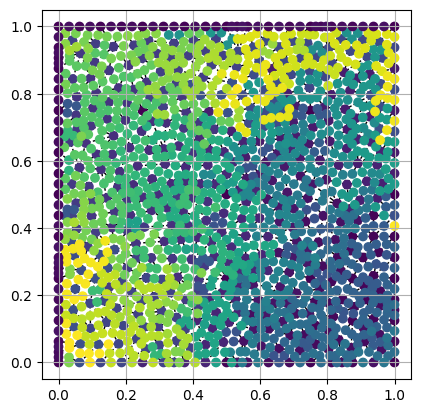

In [75]:
gedim.PlotDofs(mesh, dofs, strongs)

In [76]:
### Assembling the linear system
[stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Poisson_a, problemData, lib)
[advection, advectionStrong] = gedim.AssembleAdvectionMatrix(Poisson_b, problemData, lib)
[reaction, reactionStrong] = gedim.AssembleReactionMatrix(Poisson_c, problemData, lib)
X = stiffness + reaction

forcingTerm = gedim.AssembleForcingTerm(Poisson_f, problemData, lib)
solutionStrong = gedim.AssembleStrongSolution(Poisson_strongTerm, 1, problemData, lib)
weakTerm_right = gedim.AssembleWeakTerm(Poisson_weakTerm_right, 2, problemData, lib)
weakTerm_sotto = gedim.AssembleWeakTerm(Poisson_weakTerm_sotto, 3, problemData, lib)

In [77]:
def Solve_full_order(stiffness, advection, forcingTerm, stiffnessStrong, advectionStrong, weakTerm_right, weakTerm_sotto, mu_1, mu_2, solutionStrong):
  lhs = mu_1 * stiffness + advection
  rhs_forcing = forcingTerm
  rhs_strong = (stiffnessStrong + advectionStrong) @ solutionStrong
  rhs_week = weakTerm_right + mu_2 * weakTerm_sotto
  rhs = rhs_forcing - rhs_strong + rhs_week

  return gedim.LUSolver (lhs, rhs, lib)

In [79]:
### Creating the mesh where we evaluate the PINN
numeroDOF = problemData['NumberDOFs']
numero_nodi_dir = problemData['NumberStrongs']
numPoints = numeroDOF + numero_nodi_dir
points = np.concatenate((dofs.T,strongs.T))

#Set-up for the computation of speed-up and error analysis
mu1_range =[0.1, 10]
mu2_range =[-1, 1]
P = np.array([mu1_range, mu2_range])

In [80]:
def Avg_error(stiffness, advection, forcingTerm, stiffnessStrong, advectionStrong, weakTerm_right, weakTerm_sotto,points, numPoints, P, solutionStrong):

    np.random.seed(seme)

    abs_err = []
    rel_err = []
    L_inf = []
    testing_set = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(100, P.shape[0]))
    speed_up = []

    print("Computing error and speedup analysis...")

    for mu in testing_set:
        mu_1 = mu[0]
        mu_2 = mu[1]

        ##### FOM #####
        start_fom = time.time()
        full_solution = Solve_full_order(stiffness, advection, forcingTerm, stiffnessStrong, advectionStrong, weakTerm_right, weakTerm_sotto, mu_1, mu_2, solutionStrong)
        time_fom = time.time() - start_fom

        #Set-up for PINN
        x=points[:,0]
        y=points[:,1]
        ms_x, ms_y = np.meshgrid(x, y)
        x = x.reshape(-1,1)
        y = y.reshape(-1,1)
        pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True)
        pt_y = Variable(torch.from_numpy(y).float(), requires_grad=True)
        mu_1 = mu_1 * torch.ones(pt_x.shape[0],1)
        mu_2 = mu_2 * torch.ones(pt_x.shape[0],1)

        #### PINN #####
        start_PINN = time.time()
        pt_u = net(pt_x, pt_y, mu_1, mu_2) # Solution
        time_PINN = time.time() - start_PINN

        PINN_solution=pt_u.data.cpu().numpy()
        u = PINN_solution[:dofs.shape[1]]

        speed_up.append(time_fom / time_PINN)

        ### Computation of the errors
        error_function = np.reshape(full_solution, (u.shape)) - u

        error_norm_squared_component = np.transpose(error_function) @ X @ error_function

        absolute_error = np.sqrt(abs(error_norm_squared_component))
        abs_err.append(absolute_error)

        L_inf_err = np.max(np.abs(error_function))  # infinity norm error
        L_inf.append(L_inf_err)

        full_solution_norm_squared_component = np.transpose(full_solution) @  X @ full_solution

        relative_error = absolute_error/np.sqrt(abs(full_solution_norm_squared_component))
        rel_err.append(relative_error)

    return [rel_err, abs_err, L_inf, speed_up]

[rel_err_PINN, abs_err_PINN, L_inf_PINN, speed_up_PINN] = Avg_error(stiffness, advection, forcingTerm, stiffnessStrong, advectionStrong, weakTerm_right, weakTerm_sotto,points, numPoints, P, solutionStrong)
print("- Average PINN relative error = ", '{:.16e}'.format(np.mean(rel_err_PINN)) )
print("- Average PINN absolute error = ", '{:.16e}'.format(np.mean(abs_err_PINN)) )
print("- Average PINN L_inf error = ", '{:.16e}'.format(np.mean(L_inf_PINN)) )
print("- Average PINN speed_up       = ", '{:.16e}'.format(np.mean(speed_up_PINN)))

print("- Standard deviation PINN relative error = ", '{:.16e}'.format(np.std(rel_err_PINN)) )
print("- Standard deviation PINN absolute error = ", '{:.16e}'.format(np.std(abs_err_PINN)) )
print("- Standard deviation PINN L_inf error = ", '{:.16e}'.format(np.std(L_inf_PINN)) )
print("- Standard deviation PINN speed_up       = ", '{:.16e}'.format(np.std(speed_up_PINN)))

Computing error and speedup analysis...
- Average PINN relative error =  1.4729059985557962e+00
- Average PINN absolute error =  1.1616880476464175e-01
- Average PINN L_inf error =  1.0092180782255411e-01
- Average PINN speed_up       =  1.0929698122821078e+01
- Standard deviation PINN relative error =  1.7085047738129109e+00
- Standard deviation PINN absolute error =  1.9638534990063258e-01
- Standard deviation PINN L_inf error =  1.6124681095242366e-01
- Standard deviation PINN speed_up       =  1.6516768372645023e+00
